In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import numpy as np
import pandas as pd

In [2]:
# Load ERA5 Data
# this covers the period 2020-2023 and is in 9x9 grid
era5 = xr.open_dataset('converted_era5_data/era5_marshall_events_202002-202304.nc')
era5

<xarray.Dataset>
Dimensions:     (time: 27600, lon: 9, lat: 9)
Coordinates:
  * time        (time) datetime64[ns] 2020-02-07 ... 2023-04-01T23:00:00
  * lon         (lon) float64 -106.2 -105.9 -105.7 ... -104.7 -104.4 -104.2
  * lat         (lat) float64 40.95 40.7 40.45 40.2 39.95 39.7 39.45 39.2 38.95
Data variables:
    t2m         (time, lat, lon) float32 ...
    tp          (time, lat, lon) float32 ...
    u10         (time, lat, lon) float32 ...
    v10         (time, lat, lon) float32 ...
    wind_speed  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Oct 22 16:36:36 2024: cdo -f nc copy era5_data/era5_mar...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [3]:
# load hourly station data
marshall_hourly_df = pd.read_csv("station_data_processed/marshall_hourly_aggregated_data.csv", index_col=0,  parse_dates=True)
marshall_hourly_df.head()
#marshall_hourly_df["tipping"].dropna()

# Filter the DataFrames within the time window
filtered_hourly = marshall_hourly_df.loc['2020-02-07 00:00:00':'2023-04-01 23:00:00']
filtered_hourly

,bmp180_temp,bmp180_pres,bmp180_slp,htu_temp,htu_hum,mcp9808,tipping,vis_light,ir_light,uv_light,wind_dir,wind_speed
datetime,,,,,,,,,,,,
2020-02-07 00:00:00,-0.80,812.185,1006.200,-0.60,68.50,-0.60,0.0,262.0,264.5,3.0,94.558150,1.746034
2020-02-07 01:00:00,-1.60,813.160,1008.110,-1.40,90.35,-1.40,0.0,260.0,254.0,NaN,43.820630,2.793729
2020-02-07 02:00:00,-2.30,813.570,1009.240,-2.10,NaN,-2.15,0.0,261.0,253.0,NaN,70.296905,1.226140
2020-02-07 03:00:00,-2.40,813.970,1009.720,-2.20,NaN,-2.20,0.0,260.0,253.5,NaN,67.389274,0.905763
2020-02-07 04:00:00,-4.95,815.010,1013.135,-4.75,NaN,-4.80,0.0,260.5,NaN,NaN,12.912352,5.731207
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-01 19:00:00,15.20,821.710,1006.165,15.30,15.30,15.40,0.0,811.0,6379.0,297.0,193.002719,5.475455
2023-04-01 20:00:00,15.60,820.685,1004.735,15.70,14.15,15.90,0.0,769.5,5921.0,274.5,201.802096,6.279649
2023-04-01 21:00:00,16.00,819.580,1003.125,16.20,12.55,16.15,0.0,686.5,5002.0,230.0,206.152078,7.765091


In [4]:
measurement_times = marshall_hourly_df['tipping'].dropna().index
measurement_times
xr_aligned = era5.reindex(time=measurement_times, method=None)  # No interpolation, fill with NaNs


In [5]:
xr_aligned

<xarray.Dataset>
Dimensions:     (time: 46388, lon: 9, lat: 9)
Coordinates:
  * time        (time) datetime64[ns] 2017-03-01T05:00:00 ... 2023-11-29T19:0...
  * lon         (lon) float64 -106.2 -105.9 -105.7 ... -104.7 -104.4 -104.2
  * lat         (lat) float64 40.95 40.7 40.45 40.2 39.95 39.7 39.45 39.2 38.95
Data variables:
    t2m         (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    tp          (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    u10         (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    v10         (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    wind_speed  (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Oct 22 16:36:36 2024: cdo -f nc copy era5_data/era5_mar...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [6]:
available_times = pd.to_datetime(era5.time.values)
available_times

DatetimeIndex(['2020-02-07 00:00:00', '2020-02-07 01:00:00',
               '2020-02-07 02:00:00', '2020-02-07 03:00:00',
               '2020-02-07 04:00:00', '2020-02-07 05:00:00',
               '2020-02-07 06:00:00', '2020-02-07 07:00:00',
               '2020-02-07 08:00:00', '2020-02-07 09:00:00',
               ...
               '2023-04-01 14:00:00', '2023-04-01 15:00:00',
               '2023-04-01 16:00:00', '2023-04-01 17:00:00',
               '2023-04-01 18:00:00', '2023-04-01 19:00:00',
               '2023-04-01 20:00:00', '2023-04-01 21:00:00',
               '2023-04-01 22:00:00', '2023-04-01 23:00:00'],
              dtype='datetime64[ns]', length=27600, freq=None)

In [7]:
measurement_times = marshall_hourly_df['tipping'].dropna().index
measurement_times

DatetimeIndex(['2017-03-01 05:00:00', '2017-03-01 18:00:00',
               '2017-03-01 19:00:00', '2017-03-01 20:00:00',
               '2017-03-01 21:00:00', '2017-03-01 22:00:00',
               '2017-03-01 23:00:00', '2017-03-02 00:00:00',
               '2017-03-02 01:00:00', '2017-03-02 02:00:00',
               ...
               '2023-11-29 01:00:00', '2023-11-29 02:00:00',
               '2023-11-29 03:00:00', '2023-11-29 04:00:00',
               '2023-11-29 05:00:00', '2023-11-29 15:00:00',
               '2023-11-29 16:00:00', '2023-11-29 17:00:00',
               '2023-11-29 18:00:00', '2023-11-29 19:00:00'],
              dtype='datetime64[ns]', name='datetime', length=46388, freq=None)

In [8]:
missing_times = available_times.difference(measurement_times)
missing_times

DatetimeIndex(['2020-02-17 18:00:00', '2020-02-17 19:00:00',
               '2020-02-17 20:00:00', '2020-02-17 21:00:00',
               '2020-02-17 22:00:00', '2020-02-17 23:00:00',
               '2020-02-18 00:00:00', '2020-02-18 01:00:00',
               '2020-02-18 02:00:00', '2020-06-20 11:00:00',
               ...
               '2023-01-17 16:00:00', '2023-01-17 17:00:00',
               '2023-01-17 18:00:00', '2023-01-17 19:00:00',
               '2023-01-17 20:00:00', '2023-01-17 21:00:00',
               '2023-01-17 22:00:00', '2023-01-17 23:00:00',
               '2023-02-19 22:00:00', '2023-02-19 23:00:00'],
              dtype='datetime64[ns]', length=2044, freq=None)

In [9]:
from era5.era5_cropper import Era5ForStationCropper

# Example station coordinates (e.g., Berlin)
station_lat = 39.9496   # Latitude
station_lon = -105.196  # Longitude


# Introduce some missing hours (gaps) for demonstration
measurements = marshall_hourly_df["tipping"]

# Paths to ERA5 datasets
original_era5_path = 'converted_era5_data/era5_marshall_events_202002-202304.nc'    # Replace with actual path
cropped_era5_path = 'Training_Marshall/cropped_data_tipping/era5_cropped_tipping.nc'      # Replace with desired output path

# Initialize the cropper
cropper = Era5ForStationCropper(
    latitude=station_lat,
    longitude=station_lon,
    measurements=measurements,
    era5_path=original_era5_path,
    era5_target_path=cropped_era5_path
)

# Execute cropping and retrieve results
cropped_dataset, missing_gaps = cropper.execute()

print("Missing timestamps:", missing_gaps)


Cropping time axis...
Selecting time slice from 2017-03-01 05:00:00 to 2023-11-29 19:00:00
Time-cropped dataset dimensions: Frozen({'time': 27600, 'lon': 9, 'lat': 9})
Dropping missing times...
Number of missing timestamps: 2044
Dataset dimensions after dropping missing times: Frozen({'time': 25556, 'lon': 9, 'lat': 9})
Cropping spatial grid...
Latitudes are sorted in descending order.
Nearest longitude: -105.196 (Index: 4)
Nearest latitude: 39.9495 (Index: 4)
Final cropping indices: start=0, end=8
Final cropping indices: start=0, end=8
Cropping longitude indices: 0 to 8
Cropping latitude indices: 0 to 8
Dataset dimensions after spatial cropping: Frozen({'time': 25556, 'lon': 8, 'lat': 8})
Longitude values after cropping: [-106.196 -105.946 -105.696 -105.446 -105.196 -104.946 -104.696 -104.446]
Latitude values after cropping: [40.95     40.699875 40.44975  40.199625 39.9495   39.699375 39.44925
 39.199125]

Inspecting cropped dataset before saving:
<xarray.Dataset>
Dimensions:     (tim

In [12]:
cropped_era5_path = 'Training_Marshall/cropped_data_tipping/era5_cropped_tipping.nc'      # Replace with desired output path
cropped_era5 = xr.open_dataset(cropped_era5_path)
cropped_era5

<xarray.Dataset>
Dimensions:     (time: 25556, lon: 8, lat: 8)
Coordinates:
  * time        (time) datetime64[ns] 2020-02-07 ... 2023-04-01T23:00:00
  * lon         (lon) float64 -106.2 -105.9 -105.7 ... -104.9 -104.7 -104.4
  * lat         (lat) float64 40.95 40.7 40.45 40.2 39.95 39.7 39.45 39.2
Data variables:
    t2m         (time, lat, lon) float32 ...
    tp          (time, lat, lon) float32 ...
    u10         (time, lat, lon) float32 ...
    v10         (time, lat, lon) float32 ...
    wind_speed  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Oct 22 16:36:36 2024: cdo -f nc copy era5_data/era5_mar...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [13]:
class FillAllTasWithValuesInNcFile():
    def __init__(self, var, values, original_path, save_to_path):
        if not isinstance(values, list) and not isinstance(values, np.ndarray):
            self.values = [values]
        else:
            self.values = values

        self.var = var
        self.original_path = original_path
        self.save_to_path = save_to_path
        self._create_filled_nc_files()

    def _create_filled_nc_files(self):
        if len(self.values) == 1:
            value = self.values[0]
            with xr.open_dataset(self.original_path) as ds:
                ds[self.var].values[:] = value
                ds.to_netcdf(self.save_to_path)
        else:
            # Get the shape of the 'tas' variable
            with xr.open_dataset(self.original_path) as ds:
                tas_shape = ds[self.var].shape

                # Reshape self.values to match the shape of 'tas'
                repeated_values = self.values[:, np.newaxis, np.newaxis] * np.ones(
                    (len(self.values), 8, 8))

                # Assign the repeated values to the 'tas' variable
                ds[self.var].values[:, :, :] = repeated_values
                ds.to_netcdf(self.save_to_path)

        return self.save_to_path

In [22]:
# Fill Tas with ....
var = "tp"
values = filtered_hourly['tipping'].dropna().values
original_path = 'Training_Marshall/cropped_data_tipping/era5_cropped_tipping.nc'
save_to_path = 'Training_Marshall/cropped_data_tipping/era5_cropped_tipping_filled.nc'

FillAllTasWithValuesInNcFile(var, values, original_path, save_to_path)



In [25]:
save_to_path = 'Training_Marshall/cropped_data_tipping/era5_cropped_tipping_filled.nc'
display_filled = xr.open_dataset(save_to_path)
display_filled

<xarray.Dataset>
Dimensions:     (time: 25556, lon: 8, lat: 8)
Coordinates:
  * time        (time) datetime64[ns] 2020-02-07 ... 2023-04-01T23:00:00
  * lon         (lon) float64 -106.2 -105.9 -105.7 ... -104.9 -104.7 -104.4
  * lat         (lat) float64 40.95 40.7 40.45 40.2 39.95 39.7 39.45 39.2
Data variables:
    t2m         (time, lat, lon) float32 ...
    tp          (time, lat, lon) float32 ...
    u10         (time, lat, lon) float32 ...
    v10         (time, lat, lon) float32 ...
    wind_speed  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Oct 22 16:36:36 2024: cdo -f nc copy era5_data/era5_mar...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [29]:
# Path to your ERA5 data file (optional)
era5_data_path = 'Training_Marshall/cropped_data_tipping/era5_cropped_tipping.nc'  # Set to None if you want to download

# Set prepare_data to False if your data is already prepared
ground_truth_data_path = "Training_Marshall/cropped_data_tipping/era5_cropped_tipping_filled.nc"

In [30]:
xr_era5 = xr.open_dataset(era5_data_path)
xr_era5

<xarray.Dataset>
Dimensions:     (time: 25556, lon: 8, lat: 8)
Coordinates:
  * time        (time) datetime64[ns] 2020-02-07 ... 2023-04-01T23:00:00
  * lon         (lon) float64 -106.2 -105.9 -105.7 ... -104.9 -104.7 -104.4
  * lat         (lat) float64 40.95 40.7 40.45 40.2 39.95 39.7 39.45 39.2
Data variables:
    t2m         (time, lat, lon) float32 ...
    tp          (time, lat, lon) float32 ...
    u10         (time, lat, lon) float32 ...
    v10         (time, lat, lon) float32 ...
    wind_speed  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Oct 22 16:36:36 2024: cdo -f nc copy era5_data/era5_mar...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [31]:
xr_gt = xr.open_dataset(ground_truth_data_path)
xr_gt

<xarray.Dataset>
Dimensions:     (time: 25556, lon: 8, lat: 8)
Coordinates:
  * time        (time) datetime64[ns] 2020-02-07 ... 2023-04-01T23:00:00
  * lon         (lon) float64 -106.2 -105.9 -105.7 ... -104.9 -104.7 -104.4
  * lat         (lat) float64 40.95 40.7 40.45 40.2 39.95 39.7 39.45 39.2
Data variables:
    t2m         (time, lat, lon) float32 ...
    tp          (time, lat, lon) float32 ...
    u10         (time, lat, lon) float32 ...
    v10         (time, lat, lon) float32 ...
    wind_speed  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Oct 22 16:36:36 2024: cdo -f nc copy era5_data/era5_mar...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [32]:
def split_and_save_data_with_ratio(xr_gt, xr_era5, split_ratio, 
                                   gt_train_file, era5_train_file, 
                                   gt_val_file, era5_val_file, 
                                   gt_test_file, era5_test_file):
    # Calculate split indices based on the ratio and dataset length
    total_length = xr_gt.sizes['time']
    train_end = int(total_length * split_ratio[0])
    val_end = train_end + int(total_length * split_ratio[1])
    
    # Create and save the training, validation, and test sets
    xr_gt.isel(time=slice(0, train_end)).to_netcdf(gt_train_file)
    xr_era5.isel(time=slice(0, train_end)).to_netcdf(era5_train_file)
    
    xr_gt.isel(time=slice(train_end, val_end)).to_netcdf(gt_val_file)
    xr_era5.isel(time=slice(train_end, val_end)).to_netcdf(era5_val_file)
    
    xr_gt.isel(time=slice(val_end, None)).to_netcdf(gt_test_file)
    xr_era5.isel(time=slice(val_end, None)).to_netcdf(era5_test_file)

# Define the split ratio as (train, validation, test)
split_ratio = (0.8, 0.1, 0.1)  # 80% train, 10% validation, 10% test

# Define the file paths for each split
gt_train_file = 'Training_Marshall/cropped_data_tipping/splits/marshall_station_filltas_train.nc'
era5_train_file = 'Training_Marshall/cropped_data_tipping/splits/marshall_station_input_train.nc'
gt_val_file = 'Training_Marshall/cropped_data_tipping/splits/marshall_station_filltas_val.nc'
era5_val_file = 'Training_Marshall/cropped_data_tipping/splits/marshall_station_input_val.nc'
gt_test_file = 'Training_Marshall/cropped_data_tipping/splits/marshall_station_filltas_test.nc'
era5_test_file = 'Training_Marshall/cropped_data_tipping/splits/marshall_station_input_test.nc'

# Run the function
split_and_save_data_with_ratio(xr_gt, xr_era5, split_ratio, 
                               gt_train_file, era5_train_file, 
                               gt_val_file, era5_val_file, 
                               gt_test_file, era5_test_file)


In [33]:
# Assume you saved the class in a file named training_preparation.py
from train_station_twin.prepare_training_executor_era5 import TrainingPreparation

# Initialize the class
prep = TrainingPreparation(base_dir='executed_trainings', station_name='Marshall_tp_prepare')




2024-11-12 17:05:03,703 INFO:Created station directory at executed_trainings/Marshall_tp_prepare_20241112-170503.
2024-11-12 17:05:03,704 INFO:Created directory: executed_trainings/Marshall_tp_prepare_20241112-170503/data
2024-11-12 17:05:03,705 INFO:Created directory: executed_trainings/Marshall_tp_prepare_20241112-170503/model
2024-11-12 17:05:03,707 INFO:Created directory: executed_trainings/Marshall_tp_prepare_20241112-170503/log
2024-11-12 17:05:03,708 INFO:Created directory: executed_trainings/Marshall_tp_prepare_20241112-170503/data/train
2024-11-12 17:05:03,709 INFO:Created directory: executed_trainings/Marshall_tp_prepare_20241112-170503/data/val
2024-11-12 17:05:03,710 INFO:Created directory: executed_trainings/Marshall_tp_prepare_20241112-170503/data/test


In [34]:
prep.copy_and_prepare_data(
    dataset_type='train',
    input_src=gt_train_file,
    output_src=era5_train_file
)

# Copy and prepare validation data
prep.copy_and_prepare_data(
    dataset_type='val',
    input_src=gt_val_file,
    output_src=era5_val_file
)

# Copy and prepare test data
prep.copy_and_prepare_data(
    dataset_type='test',
    input_src=gt_test_file,
    output_src=era5_test_file
)


2024-11-12 17:06:40,954 INFO:Starting to copy and prepare data for train dataset.
2024-11-12 17:06:40,977 INFO:Copied input file from Training_Marshall/cropped_data_tipping/splits/marshall_station_filltas_train.nc to executed_trainings/Marshall_tp_prepare_20241112-170503/data/train/input.nc.
2024-11-12 17:06:42,107 INFO:Converted executed_trainings/Marshall_tp_prepare_20241112-170503/data/train/input.nc to float32.
2024-11-12 17:06:42,137 INFO:Copied output file from Training_Marshall/cropped_data_tipping/splits/marshall_station_input_train.nc to executed_trainings/Marshall_tp_prepare_20241112-170503/data/train/output.nc.
2024-11-12 17:06:43,028 INFO:Converted executed_trainings/Marshall_tp_prepare_20241112-170503/data/train/output.nc to float32.
2024-11-12 17:06:43,080 INFO:Alignment check passed for train dataset.
2024-11-12 17:06:43,134 INFO:Variable names check passed for train dataset.
2024-11-12 17:06:43,135 INFO:Completed copying and processing data for train dataset.
2024-11-12

In [55]:
# Prepare training arguments
prep.prepare_training_args(data_types_in="tp", data_types_out="tp", total_iterations=100000)

2024-11-12 17:28:45,975 INFO:Training arguments saved to executed_trainings/Marshall_tp_prepare_20241112-170503/train_args.txt.


'executed_trainings/Marshall_tp_prepare_20241112-170503/train_args.txt'

In [36]:
# Assume the model has been trained and saved at 'path/to/model.pth'
model_path = 'executed_trainings/Marshall_tp_prepare_20241112-170503/model/ckpt/best.pth'

# Define the names of the input and output NetCDF files used during evaluation
input_filename = 'input.nc'
output_filename = 'output.nc'
data_types_in = "tp"
data_types_out = "tp"

# Define the output directory for evaluation results
evaluation_output_dir = 'executed_trainings/Marshall_tp_prepare_20241112-170503'

# Prepare evaluation arguments
eval_args_path = prep.prepare_eval_args(model_path, input_filename, output_filename, data_types_in, data_types_out,
                          evaluation_output_dir, loss_criterion=3, device='cpu',
                          n_filters=18, out_channels=1, normalize_data=True,
                          use_train_stats=True, output_path=None)


2024-11-12 17:20:39,489 INFO:Evaluation arguments saved to executed_trainings/Marshall_tp_prepare_20241112-170503/eval_args.txt.


In [56]:
output_output = xr.open_dataset("executed_trainings/Marshall_tp_prepare_20241112-170503/output_output.nc")
output_output

<xarray.Dataset>
Dimensions:     (lon: 8, lat: 8, time: 2557)
Coordinates:
  * lon         (lon) float64 -106.2 -105.9 -105.7 ... -104.9 -104.7 -104.4
  * lat         (lat) float64 40.95 40.7 40.45 40.2 39.95 39.7 39.45 39.2
  * time        (time) datetime64[ns] 2022-11-27T06:00:00 ... 2023-04-01T23:0...
Data variables:
    tp          (time, lat, lon) float32 ...
    t2m         (time, lat, lon) float32 ...
    u10         (time, lat, lon) float32 ...
    v10         (time, lat, lon) float32 ...
    wind_speed  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Infilled using CRAI (Climate Reconstruction AI: https://git...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [57]:
output_gt = xr.open_dataset("executed_trainings/Marshall_tp_prepare_20241112-170503/output_gt.nc")
output_gt

<xarray.Dataset>
Dimensions:     (lon: 8, lat: 8, time: 2557)
Coordinates:
  * lon         (lon) float64 -106.2 -105.9 -105.7 ... -104.9 -104.7 -104.4
  * lat         (lat) float64 40.95 40.7 40.45 40.2 39.95 39.7 39.45 39.2
  * time        (time) datetime64[ns] 2022-11-27T06:00:00 ... 2023-04-01T23:0...
Data variables:
    tp          (time, lat, lon) float32 ...
    t2m         (time, lat, lon) float32 ...
    u10         (time, lat, lon) float32 ...
    v10         (time, lat, lon) float32 ...
    wind_speed  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.4.2 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Infilled using CRAI (Climate Reconstruction AI: https://git...
    CDO:          Climate Data Operators version 2.4.2 (https://mpimet.mpg.de...

In [58]:
def median_per_timestep(data: xr.DataArray) -> xr.DataArray:
    """
    Calculate the median along the 'time' dimension for an xarray DataArray.
    
    Parameters:
    data (xr.DataArray): Input DataArray with a 'time' dimension.
    
    Returns:
    xr.DataArray: DataArray with the median calculated along the 'time' dimension.
    """
    return data.median(dim=['lat', 'lon'])

median_output_output = median_per_timestep(output_output)
median_output_gt = median_per_timestep(output_gt)

In [59]:
median_output_output

<xarray.Dataset>
Dimensions:     (time: 2557)
Coordinates:
  * time        (time) datetime64[ns] 2022-11-27T06:00:00 ... 2023-04-01T23:0...
Data variables:
    tp          (time) float32 0.0003971 0.0003971 ... 0.0003971 0.0003971
    t2m         (time) float32 -2.268 -2.582 -3.126 -3.637 ... 9.194 8.964 8.737
    u10         (time) float32 -0.03051 0.2774 0.1869 ... 3.836 3.178 2.996
    v10         (time) float32 -0.4563 -0.3522 -0.005843 ... 2.109 0.9583 1.243
    wind_speed  (time) float32 1.28 1.158 1.154 1.127 ... 4.674 4.707 3.61 3.414

In [60]:
median_output_gt

<xarray.Dataset>
Dimensions:     (time: 2557)
Coordinates:
  * time        (time) datetime64[ns] 2022-11-27T06:00:00 ... 2023-04-01T23:0...
Data variables:
    tp          (time) float32 0.3058 0.1913 0.1564 0.1174 ... 0.0 0.0 0.0 0.0
    t2m         (time) float32 -2.268 -2.582 -3.126 -3.637 ... 9.194 8.964 8.737
    u10         (time) float32 -0.03051 0.2774 0.1869 ... 3.836 3.178 2.996
    v10         (time) float32 -0.4563 -0.3522 -0.005843 ... 2.109 0.9583 1.243
    wind_speed  (time) float32 1.28 1.158 1.154 1.127 ... 4.674 4.707 3.61 3.414

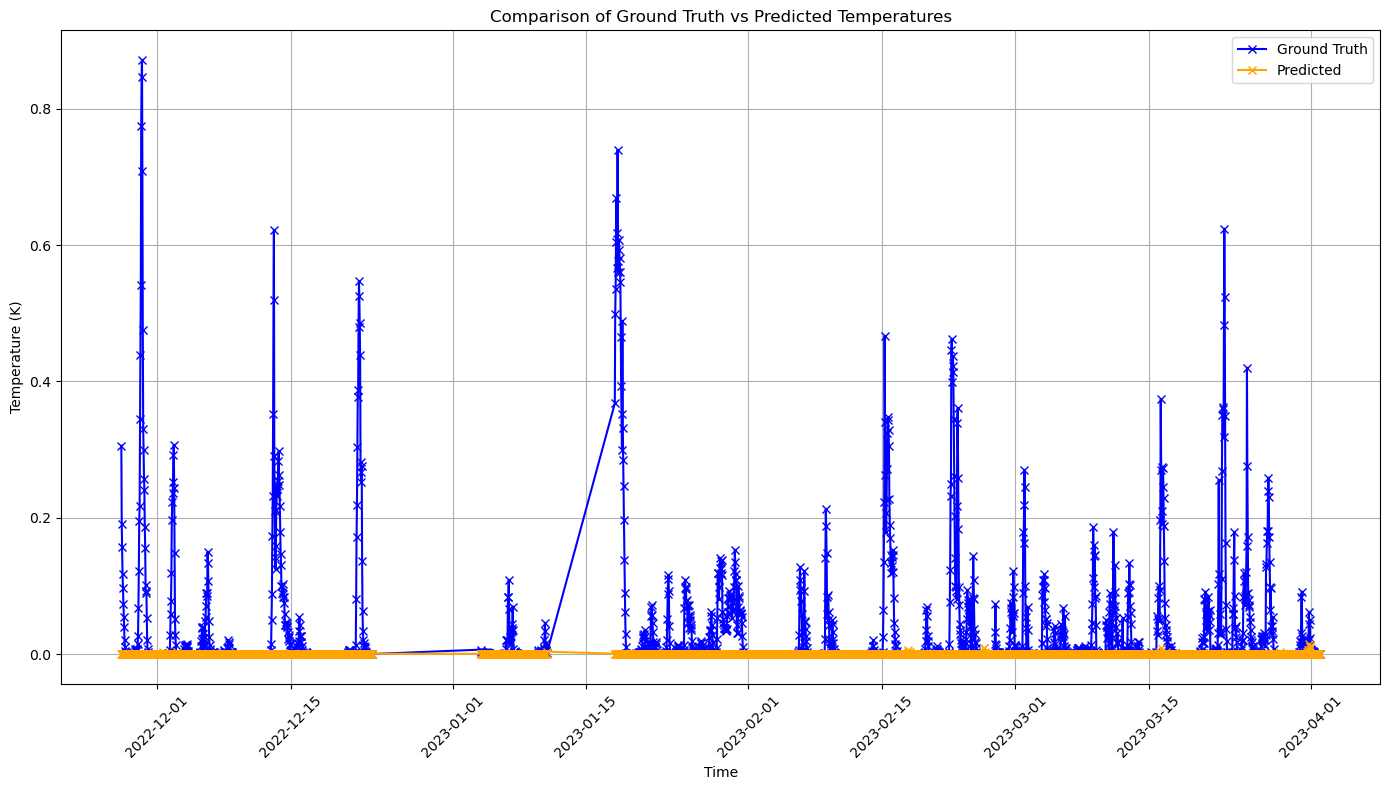

In [61]:
def improved_plot_datasets(ds1: xr.DataArray, ds2: xr.DataArray, title1="Ground Truth", title2="Predicted"):
    """
    Improved plot for two xarray DataArrays over time, with enhancements.

    Parameters:
    ds1 (xr.DataArray): First DataArray to plot.
    ds2 (xr.DataArray): Second DataArray to plot.
    title1 (str): Label for the first dataset.
    title2 (str): Label for the second dataset.
    """
    # Align datasets to ensure they share the same time axis
    ds1, ds2 = xr.align(ds1, ds2)

    # Create a larger figure
    plt.figure(figsize=(14, 8))

    # Plot each dataset with markers and handle missing values (NaN)
    plt.plot(ds1.time, ds1.tp.where(~ds1.tp.isnull()), label=title1, marker='x', linestyle='-', color='blue')
    plt.plot(ds2.time, ds2.tp.where(~ds2.tp.isnull()), label=title2, marker='x', linestyle='-', color='orange')

    # Adding labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel('Temperature (K)')
    plt.title('Comparison of Ground Truth vs Predicted Temperatures')
    plt.legend()

    # Rotate x-axis labels and add grid for better readability
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Usage
improved_plot_datasets(median_output_gt, median_output_output)


In [62]:
import numpy as np
import xarray as xr
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

def calculate_metrics(ds1: xr.DataArray, ds2: xr.DataArray, var: str) -> dict:
    """
    Calculate R^2, RMSE, and Pearson correlation between two xarray DataArrays.

    Parameters:
    ds1 (xr.DataArray): First DataArray (e.g., ground truth).
    ds2 (xr.DataArray): Second DataArray (e.g., predictions).
    var (str): Variable name to select within the DataArrays.

    Returns:
    dict: Dictionary containing R^2, RMSE, and Pearson correlation.
    """
    # Align datasets to ensure they share the same time axis
    ds1, ds2 = xr.align(ds1, ds2)

    # Select the variable and flatten data, removing NaNs for comparison
    ds1_flat = ds1[var].values.flatten()
    ds2_flat = ds2[var].values.flatten()

    # Remove NaN values from both arrays
    mask = ~np.isnan(ds1_flat) & ~np.isnan(ds2_flat)
    ds1_flat = ds1_flat[mask]
    ds2_flat = ds2_flat[mask]

    # Calculate metrics
    r2 = r2_score(ds1_flat, ds2_flat)
    rmse = np.sqrt(mean_squared_error(ds1_flat, ds2_flat))
    pearson_corr, _ = pearsonr(ds1_flat, ds2_flat)

    return {
        "R^2": r2,
        "RMSE": rmse,
        "Pearson Correlation": pearson_corr
    }




In [63]:
metrics = calculate_metrics(median_output_gt, median_output_output, "tp")
print(metrics)


{'R^2': -0.14070853976535336, 'RMSE': 0.09562965, 'Pearson Correlation': 0.007257711273223536}
